## Download the CIFAR10 dataset

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Input, Dropout
from keras.layers.normalization import BatchNormalization
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras import optimizers
from keras import regularizers
import matplotlib.pyplot as plt
import keras
from keras import Model

Using TensorFlow backend.


In [3]:
(X_train,y_train),(X_test,y_test)=cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

170500096/170498071 [==============================] - 4s 0us/step


## Normalize the data such that it will reside in the range [-0.5,0.5]

In [0]:
def normalize(x):
  max_val = x.max()
  min_val = x.min()

  return ((x - min_val) / (max_val - min_val)) - 0.5

In [0]:
X_train = normalize(X_train)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test = normalize(X_test)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

## Train a linear classifier using a softmax activation on the training set without any regularization


In [6]:
model_flat = Sequential([
    Dense(10, input_shape=(X_train_flat.shape[1],)),
    Activation('softmax'),
])

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_flat.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_flat = model_flat.fit(x=X_train_flat, 
                              y=y_train, 
                              epochs=100, 
                              batch_size=32,
                              validation_data=(X_test_flat, y_test))









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/100





50000/50000 [==============================] - 14s 288us/step - loss: 1.8775 - acc: 0.3519 - val_loss: 1.7941 - val_acc: 0.3824
Epoch 2/100
50000/50000 [==============================] - 5s 102us/step - loss: 1.7730 - acc: 0.3942 - val_loss: 1.7604 - val_acc: 0.3938
Epoch 3/100
50000/50000 [==============================] - 5s 102us/step - loss: 1.7425 - acc: 0.4045 - val_loss: 1.7397 - val_acc: 0.4021
Epoch 4/100
50000/50000 [==============================] - 5s 100us/step - loss: 1.7245 - acc: 0.4128 - val_loss: 1.7334 - val_acc: 0.4039
Epoch 5/100
50000/50000 [==============================] - 5s 100us/step - loss: 1.7130 - acc: 0.4145 - val_loss: 1.7238 - val_acc: 0.4050
Epoch 6/100
50000/50000 [==============================] - 5s 101us/step - loss: 1.7038 - acc: 0.4192 - val_loss: 1.7207 - val_acc: 0.4082
Epoch 7/

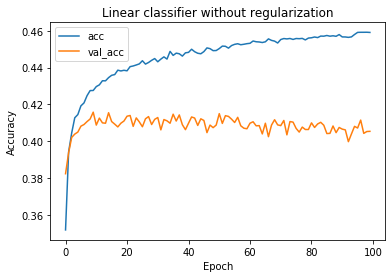

In [7]:
plt.figure()
plt.title("Linear classifier without regularization")
plt.plot(history_flat.history['acc'], label='acc')
plt.plot(history_flat.history['val_acc'], label='val_acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

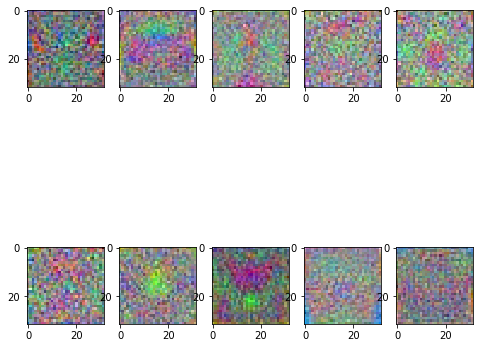

In [8]:
def plot_weights(arch):
  dlayer = arch.layers[0].get_weights()
  mat = dlayer[0]
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  columns = 5
  rows = 2
  for i in range(1, columns*rows +1):
      img = mat[:, i-1].reshape(X_train.shape[1:])
      img = normalize(img) + 0.5
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
  plt.show()



plot_weights(model_flat)

Train another linear classifier, this time use L2 regularization with a multiplier of 0.1

In [9]:
model_reg = Sequential([
    Dense(10, input_shape=(X_train_flat.shape[1], ), kernel_regularizer=regularizers.l2(0.1)),
    Activation('softmax'),
])

model_reg.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_flat_reg = model_reg.fit(x=X_train_flat, 
                                  y=y_train, 
                                  epochs=100, 
                                  batch_size=32,
                                  validation_data=(X_test_flat, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 5s 98us/step - loss: 2.3664 - acc: 0.3409 - val_loss: 1.9769 - val_acc: 0.3721
Epoch 2/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.9742 - acc: 0.3629 - val_loss: 1.9691 - val_acc: 0.3670
Epoch 3/100
50000/50000 [==============================] - 5s 98us/step - loss: 1.9709 - acc: 0.3639 - val_loss: 1.9641 - val_acc: 0.3664
Epoch 4/100
50000/50000 [==============================] - 5s 98us/step - loss: 1.9703 - acc: 0.3646 - val_loss: 1.9667 - val_acc: 0.3702
Epoch 5/100
50000/50000 [==============================] - 5s 96us/step - loss: 1.9706 - acc: 0.3644 - val_loss: 1.9651 - val_acc: 0.3621
Epoch 6/100
50000/50000 [==============================] - 5s 101us/step - loss: 1.9704 - acc: 0.3647 - val_loss: 1.9631 - val_acc: 0.3622
Epoch 7/100
50000/50000 [==============================] - 5s 98us/step - loss: 1.9701 - acc: 0.3642 - val_loss: 1.9625 -

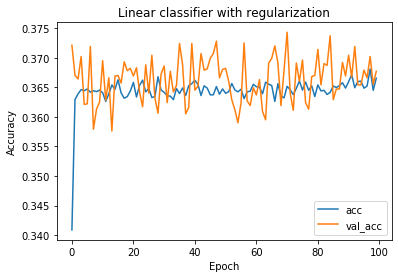

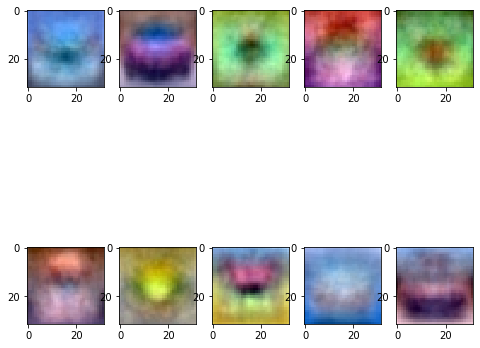

In [10]:
plt.figure()
plt.title("Linear classifier with regularization")
plt.plot(history_flat_reg.history['acc'], label='acc')
plt.plot(history_flat_reg.history['val_acc'], label='val_acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plot_weights(model_reg)

## Train a convolutional neural network

In [0]:
def build_regular_model():
    """
    Function for retrieving the model
    :return: A keras model which is able to achieve over 85% val_acc
    """
    input = Input((32, 32, 3))
    y = Conv2D(32, (3, 3), activation="relu")(input)
    y = BatchNormalization()(y)
    y = Conv2D(44, (2, 2), activation="relu", padding='same')(y)
    y = BatchNormalization()(y)
    y = MaxPool2D()(y)
    y = Conv2D(48, (2, 2), activation="relu")(y)
    y = BatchNormalization()(y)
    y = Conv2D(56, (2, 2), activation="relu", padding='same')(y)
    y = BatchNormalization()(y)
    y = MaxPool2D()(y)
    y = Conv2D(64, (2, 2), activation="relu")(y)
    y = Dropout(0.5)(y)
    y = BatchNormalization()(y)
    y = MaxPool2D()(y)
    y = Conv2D(32, (2, 2), activation="sigmoid")(y)
    y = BatchNormalization()(y)
    y = keras.layers.GlobalAveragePooling2D()(y)
    y = Dropout(0.5)(y)
    output = Dense(10, activation='softmax')(y)
    return Model(inputs=input, outputs=output)

In [12]:
model_conv = build_regular_model()
model_conv.summary()

model_conv.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_conv = model_conv.fit(x=X_train, 
                              y=y_train, 
                              epochs=100, 
                              batch_size=32,
                              validation_data=(X_test, y_test))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 44)        5676      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 44)        176       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 44)        0         
_______

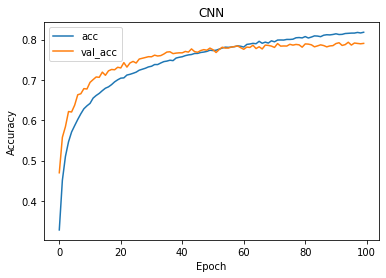

In [13]:
plt.figure()
plt.title("CNN")
plt.plot(history_conv.history['acc'], label='acc')
plt.plot(history_conv.history['val_acc'], label='val_acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Test on 2 new images

In [15]:
from PIL import Image
import PIL
import numpy as np

def classify(p):
  img = Image.open(p)
  img = img.resize((32,32), resample=PIL.Image.LANCZOS).convert("RGB")
  img = normalize(np.expand_dims(np.array(img), axis=0))
  p = model_conv.predict(img)
  print(p)
  print(np.argmax(p))

classify('image1.png')
classify('image2.jpg')

[[9.9699378e-01 9.5261133e-04 1.5820772e-03 1.2705749e-04 9.2898117e-05
  9.5264031e-06 8.0205900e-06 1.7407530e-05 2.0618134e-04 1.0513910e-05]]
0
[[1.9292253e-03 9.7336811e-01 6.1348372e-04 2.1071297e-03 3.3282992e-04
  8.2015339e-04 1.6128223e-02 9.2006980e-05 8.4367336e-04 3.7650766e-03]]
1
